# Magnetic and Diagenetic Analyses of Kawamura (2009)
_____

Paper doi: 10.2204/iodp.proc.303306.209.2009

Core: IODP Expedition 303 Site U1308 (49°52.7′N, 24°14.3′W)

Water depth: 3871 m

Data in analysis: Magnetite ppm (from Ms measurements), sedimentation rate, total organic carbon, pore water chemistry.

The high-resolution age model uses a revised composite splice, which differs only slightly from the original splice in IODP proceedings. Using that gives higher resolution sed rates, but their depths may be incorrect by a few meters. Deciding to use the original sed rates to avoid depth inaccuracies.

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import data_fns
%matplotlib inline
plt.rcParams["font.family"] = "Avenir"

In [2]:
# read in data
magn = pd.read_excel("data/kawamura2009/1308.xlsx", sheet_name="1308 Ms")
geochem = pd.read_excel("data/kawamura2009/1308.xlsx", sheet_name="geochem")
toc = pd.read_excel("data/kawamura2009/1308.xlsx", sheet_name="toc")
ages = pd.read_excel("data/kawamura2009/1308.xlsx", sheet_name="ages")

# unit adjustments
# there is a scaling factor for each Ms measurement, plus the usual conversion to magnetite
magn["Magnetite [ppm]"] = (magn["Ms (Am^2/kg)"] * 10**6) / (92 * (10 ** magn["Negative Factor"]))
ages["Paper Age [Ma]"] = ages["paper age [ka]"] / 1000

In [3]:
# calculate sed rates
# choose which one you want to use
ship_sed_rates = data_fns.sed_rates(ages["ship age (Ma)"], ages["Depth (mcd)"])
paper_sed_rates = data_fns.sed_rates(ages["Paper Age [Ma]"], ages["Depth [rmcd]"])

In [4]:
# combine stuff together
magn_df = pd.DataFrame({"Depth [mbsf]":magn["Depth (ship mcd)"], "Magnetite [ppm]":magn["Magnetite [ppm]"]})
geochem_df = pd.DataFrame({"Depth [mbsf]":geochem["Depth (mcd)"], "Sulfate [mM]":geochem["Sulfate(SO4) (mM)"], "Fe 2+ [uM]":geochem["Iron(Fe 2+) (uM)"]})
toc_df = pd.DataFrame({"Depth [mbsf]":toc["Depth (mcd)"], "TOC [wt. %]":toc["ORG_C (wt %)"]})
seds_df = pd.DataFrame({"Depth [mbsf]":ages["Depth [rmcd]"], "Sedimentation Rate [m/Ma]":paper_sed_rates})

comb_df = pd.concat([magn_df, geochem_df, toc_df, seds_df]).sort_values(by="Depth [mbsf]").reset_index(drop=True)

# there are some rows with all nans, due to the input data
# dropping those now for cleanliness and so that interpolation works
comb_df.dropna(subset=["Depth [mbsf]"], inplace=True)


In [5]:
# interpolate
interpolated = data_fns.interpolate(comb_df, ["Sulfate [mM]", "TOC [wt. %]", "Fe 2+ [uM]"])

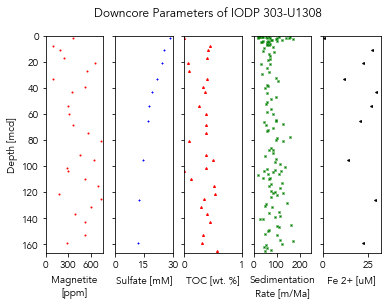

In [9]:
# downcore plots
colors = ["r", "b", "r", "g", "k"]
markers = [".", "+", "^", "x", "<"]
comp_markers = [".", ".", ".", "."]
dc_fig, dc_axs = data_fns.plot_dc(["Magnetite [ppm]", "Sulfate [mM]", "TOC [wt. %]", "Sedimentation Rate [m/Ma]", "Fe 2+ [uM]"], comb_df, colors, markers)
dc_fig.suptitle("Downcore Parameters of IODP 303-U1308", x=0.5)
dc_axs[0].set_ylabel("Depth [mcd]")
dc_axs[0].set_xlabel("Magnetite\n[ppm]")
dc_axs[3].set_xlabel("Sedimentation\nRate [m/Ma]")
dc_axs[0].set_xticks([0, 300, 600])
dc_axs[1].set_xticks([0, 15, 30])
#dc_axs[1].set_xlim(0, 30)
dc_axs[2].set_xlim(0, 1)
dc_axs[3].set_xlim(0, 250)
dc_axs[3].set_xticks([0, 100, 200])
dc_fig.savefig("outputs/kawamura2009/1308/dc.pdf", bbox_inches="tight")

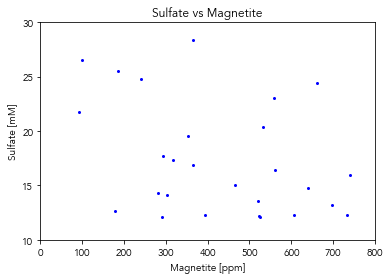

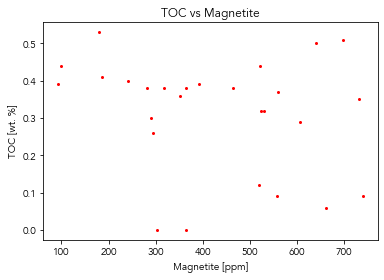

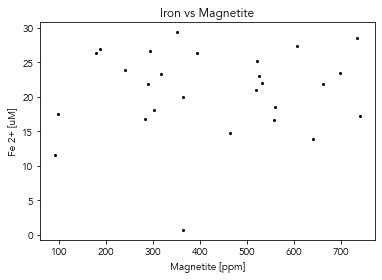

In [19]:
# comparison plots
comp_figs, comp_axs = data_fns.plot_comp(["Sulfate [mM]", "TOC [wt. %]", "Fe 2+ [uM]"], interpolated, ["b", "r", "k"], comp_markers, markersize=4)
comp_axs[0].set(xlabel="Magnetite [ppm]", ylabel="Sulfate [mM]", title="Sulfate vs Magnetite", ylim=[10,30], xlim=[0,800])
comp_axs[0].set_yticks([10,15,20,25,30])
comp_axs[1].set(xlabel="Magnetite [ppm]", ylabel="TOC [wt. %]", title="TOC vs Magnetite")
comp_axs[2].set(xlabel="Magnetite [ppm]", ylabel="Fe 2+ [uM]", title="Iron vs Magnetite")
comp_figs[0].savefig("outputs/kawamura2009/1308/sulf-comp.pdf")
comp_figs[1].savefig("outputs/kawamura2009/1308/toc-comp.pdf")
comp_figs[2].savefig("outputs/kawamura2009/1308/iron-comp.pdf")

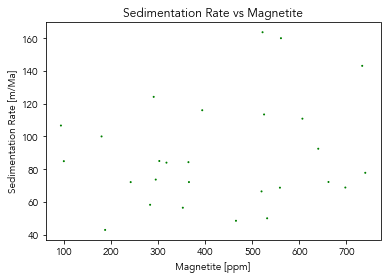

In [30]:
# plot the sed rate comp plot separately, since it has a different presentation
sed_fig, sed_ax, sed_sc = data_fns.sed_avg_plot(interpolated)
sed_ax.set(xlabel="Magnetite [ppm]", ylabel="Sedimentation Rate [m/Ma]", title = "Sedimentation Rate vs Magnetite")
sed_fig.savefig("outputs/kawamura2009/1308/sed-comp.pdf")

In [31]:
# write data to compilations
# first we have to rename the depth columns to mcd instead of mbsf
# we used mbsf above b/c it works nicely with data_fns.py
comb_df.rename(columns={"Depth [mbsf]":"Depth [mcd]"}, inplace=True)
interpolated.rename(columns={"Depth [mbsf]":"Depth [mcd]"}, inplace=True)

In [32]:
data_fns.write_output(comb_df, "IODP 303-U1308", "data/comp_raw.xlsx")
data_fns.write_output(interpolated, "IODP 303-U1308", "data/comp_inter.xlsx")
